__regular expressions__

|  特殊字符   | e.g.  | match|
|  ----  | ----  | ----  |
| *  | a*|'',aa,aaa |
| ?  | a? |'',a     |
|.   |.   | a,b,c,7,!|
|^|^b|ba,bb,..|
| \$ | a$| ba..|
| ''(空串)| ''| ''|
|ba|ba|ba|
https://www.cs.princeton.edu/courses/archive/spr09/cos333/beautiful.html

__search__
- 以^开始 match()
- 非^开头 match(.* + pattern)

__match__
- 空串 ，True
- $ ,空串则True
- p*或p? 拆分 前`p`,中`op`,后`pat`
    - p* 任意数量的p
        - 0个 pat,text
        - 多个
    - p? 
        - 0个 pat text
        - 1个 
- match1`匹配第一个字符` + match`匹配其余字符`
    - __match1__ 文本非空则 .或者普通字符为True
    

In [52]:
def search(pattern,text:str):
    "该模式出现在文本中 任何位置 返回True"
    if pattern.startswith('^'):
        return match(pattern[1:],text)
    else:
        return match('.*' + pattern,text)

def match(pattern,text:str):
    '该模式出现在文本 开头 返回True'
    if pattern == '':
        return True
    if pattern == '$':
        return (text == '')
    if len(pattern) > 1 and pattern[1] in '*?':
        p,op,pat = pattern[0],pattern[1],pattern[2:]
        if op == '*':
            return match_star(p,pat,text)
        elif op == '?':
            return(match(pat,text) or
                   (match1(p,text) and 
                   match(pat,text[1:])))
    else:
        return (match1(pattern[0],text) and
               match(pattern[1:],text[1:]))
    
def match1(p,text):
    '如果文本第一字符 匹配 p或者.'
    return (p in ('.',text[0])) if text else False

def match_star(p,pat,text):
    '任意数量的p + pat 匹配text'
    return (match(pat,text) or
        (match1(p,text) and 
         match_star(p,pat,text[1:])))

def test():
    assert search('baa*!','Sheep said baaaa!')
    assert search('baa*!','Sheep said baaaa humbug') == False
    assert match('baa*!','Sheep said baaaa!') == False
    assert match('baa*!','baaaa! said the sheep!')
    assert search('def','abcdefg')
    assert search('def$','abcdef')
    assert search('def$','abcdefg') == False
    assert search('^start','not the start') == False
    assert match('start','not the start') == False
    assert search('a*b*c*','just anything')
    assert match('x?','text')
    assert match('text?','text')
    assert match('text?','tex')
    print('test pass')
test()

test pass


- 正则是语法，描述为长字符序列
- 语法表达式变长，需要更具组合性来描述
- 描述的是API
- 描述一系列描述正则表达式语法的函数调用
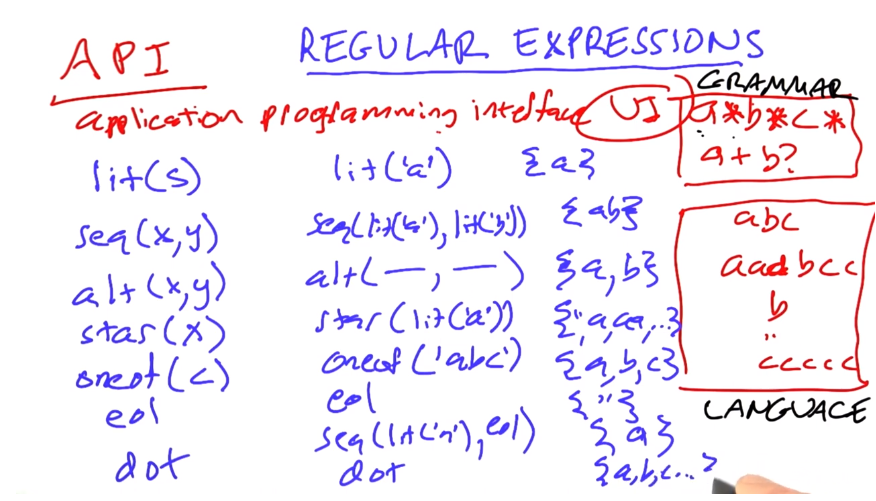

# 概念清单


In [93]:
def matchset(pattern,text:str):
    "返回 剩余文本的集合"
    op,x,y = components(pattern)
    match op:
        case 'lit':
            return set([text[(len(x)):]]) if text.startswith(pattern) else null
        case 'seq':
            return set(t2 for t1 in matchset(x,text)
                          for t2 in matchset(y,t1))
        case 'alt':
            return matchset(x,text)| matchset(y,text)
        case 'oneof':
            return set([text[1:]])if text.startswith(x) else null
        case 'dot':
            return set([text[1:]]) if text else null
        case 'eol':
            return set([''])if text == '' else null         
        case 'star':
            return (set([text]) |
                    set(t2 for t1 in matchset(x,text)
                          for t2 in matchset(pattern,t1)
                          if t1!=text))
        
null = frozenset()

def lit(string):return ('lit',string)
def seq(x,y):return ('seq',x,y)
def alt(x,y):return ('alt',x,y)
def star(x):return ('star',x)
def plus(x):return seq(x,star(x))
def opt(x):return alt(lit(''),x)
def oneof(chars): return ('oneof',tuple(chars))
dot = ('dot',)
eol = ('eol',)


def test():
    assert lit('abc')         == ('lit', 'abc')
    assert seq(('lit', 'a'),
               ('lit', 'b'))  == ('seq', ('lit', 'a'), ('lit', 'b'))
    assert alt(('lit', 'a'),
               ('lit', 'b'))  == ('alt', ('lit', 'a'), ('lit', 'b'))
    assert star(('lit', 'a')) == ('star', ('lit', 'a'))
    assert plus(('lit', 'c')) == ('seq', ('lit', 'c'),
                                  ('star', ('lit', 'c')))
    assert opt(('lit', 'x'))  == ('alt', ('lit', ''), ('lit', 'x'))
    assert oneof('abc')       == ('oneof', ('a', 'b', 'c'))
    return 'tests pass'

test()

'tests pass'

In [94]:
# math + remainder == 原文本
def search(pattern,text):
    for i in range(len(text)):
        m = match(pattern,text[i:])
        # 模式可能与空串匹配 不能 (if m:return m)
        if m is not None:
            return m

def match(pattern,text):
    remainders = matchset(pattern,text)
    if remainders:
        # 最短的余数应该是最长的文本
        shortest = min(remainders,key=len)
        return text[:len(text)-len(shortest)]

def components(pattern):
    x = pattern[1] if len(pattern)>1 else None
    y = pattern[2] if len(pattern)>2 else None
    return pattern[0],x,y

In [95]:
def test():
    assert match(('star', ('lit', 'a')), 'aaabcd') == 'aaa'
    assert match(('alt', ('lit', 'b'), ('lit', 'c')), 'ab') == None
    assert match(('alt', ('lit', 'b'), ('lit', 'a')), 'ab') == 'a'
    assert search(('alt', ('lit', 'b'), ('lit', 'c')), 'ab') == 'b'
    return 'tests pass'

def test():
    assert matchset(('lit', 'abc'), 'abcdef') == set(['def'])
    assert matchset(('seq', ('lit', 'hi '),
                     ('lit', 'there ')),
                    'hi there nice to meet you') == set(['nice to meet you'])
    assert matchset(('alt', ('lit', 'dog'),
                     ('lit', 'cat')), 'dog and cat') == set([' and cat'])
    assert matchset(('dot',), 'am i missing something?') == set(['m i missing something?'])
    assert matchset(('oneof', 'a'), 'aabc123') == set(['abc123'])
    assert matchset(('eol',), '') == set([''])
    assert matchset(('eol',), 'not end of line') == frozenset([])
    assert matchset(('star', ('lit', 'hey')), 'heyhey!') == set(['!', 'heyhey!', 'hey!'])

    return 'tests pass'

test()

tests pass


'tests pass'

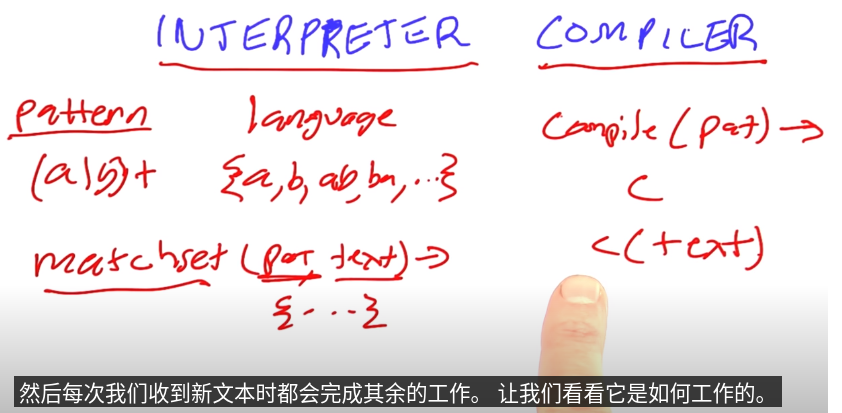
# 反汇编模块dis
- 函数作为输入 显示函数中的指令 来自python虚拟机的所谓字节码的样子

In [114]:
import dis
dis.dis(lambda x,y:abs(x**2+y**2))

  2           0 LOAD_GLOBAL              0 (abs)
              2 LOAD_FAST                0 (x)
              4 LOAD_CONST               1 (2)
              6 BINARY_POWER
              8 LOAD_FAST                1 (y)
             10 LOAD_CONST               1 (2)
             12 BINARY_POWER
             14 BINARY_ADD
             16 CALL_FUNCTION            1
             18 RETURN_VALUE


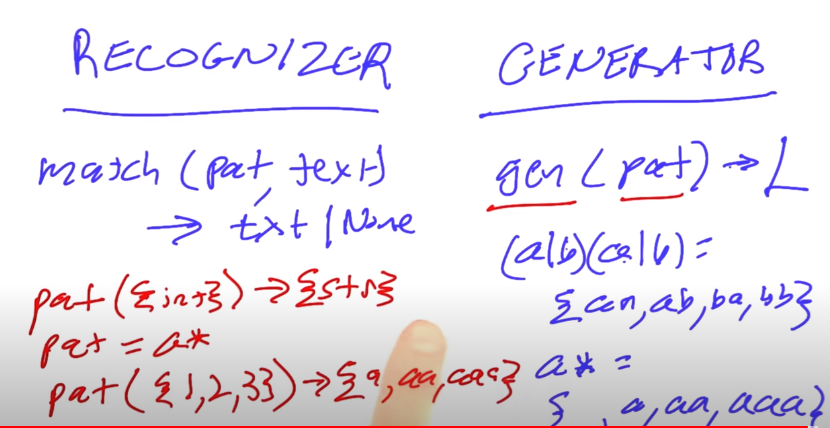
- 识别器 Recognizer
    - `mathch(pat,text)-> text|None`
    - 识别文本的前缀 是否属于 模式定义的语言
- 生成器 Generator
    - 从模式生成 由该模式定义的 完整语言

In [153]:
null = frozenset([])

def match(pattern,text):
    ""
    remainders = pattern(text)
    if remainders:
        # 最短的余数应该是最长的文本
        shortest = min(remainders,key=len)
        return text[:len(text)-len(shortest)]
    
def lit(x):
    return lambda text: set([text[(len(x)):]]) if text.startswith(x) else null

def seq(x,y):
#     return lambda text:set(t2 for t1 in matchset(x,text)
#                           for t2 in matchset(y,t1))
    "形成集合的并集 文本到集合的函数"
    return lambda text:set().union( *map(y,x(text)))

def alt(x,y):
    return lambda text: x(text)|y(text)

def oneof(chars):
    return lambda t: set([t[1:]]) if(t and t[0] in chars) else null

dot = lambda t: set([t[1:]]) if t else null
eol = lambda t: set(['']) if t=='' else null
def star(x):
    return lambda t:(set([t]) |
                    set(t2 for t1 in x(t)
                        for t2 in star(x)(t1)))


def test():
    assert match(star(lit('a')), 'aaaaabbbaa') == 'aaaaa'
    assert match(lit('hello'), 'hello how are you?') == 'hello'
    assert match(lit('x'), 'hello how are you?') == None
    assert match(oneof('xyz'), 'x**2 + y**2 = r**2') == 'x'
    assert match(oneof('xyz'), '   x is here!') == None
    return 'tests pass'

test()

'tests pass'

In [176]:
null = frozenset([])
"""
    返回一个与定义的协议相匹配的函数
        协议是：每个模式函数将用一组数字
            该组数字是：正在寻找的可能长度的列表
        该函数返回一组字符串
"""
def lit(s):
    set_s=set([s])
    return lambda Ns:set_s if len(s) in Ns else null

def alt(x,y):      return lambda Ns:x(Ns)|y(Ns)
def star(x):       return lambda Ns:opt(plus(x))(Ns)
def plus(x):       return lambda Ns:genseq(x,star(x),Ns,starx=1) #Tricky
def oneof(chars):
    set_chars = set(chars)
    return lambda Ns: set_chars if 1 in Ns else null
def seq(x,y):     return lambda Ns: genseq(x,y,Ns)
def opt(x):        return alt(epsilon,x)
dot = oneof('?')
epsilon = lit('')

def genseq(x,y,Ns,startx=0):
    # set of matches to xy whose total len is in Ns"
    # Tricky: x+ is defined as:x+=x x*
    # to stop the recursion, the first x must generate at least 1 char
    # and then the recursion x* has that many fewer characters, we use
    # startx=1 to say that x must match at least 1 character
    """
    Nss = range(max(Ns)+1)
    return set(
        m1+m2
        for m1 in x(Nss)
        for m2 in y(Nss)
        if len(m1+m2) in Ns)
    """
    if not Ns: return null
    xmatches = x(set(range(startx,max(Ns)+1)))
    Ns_x = set(len(m) for m in xmatches)
    Ns_y = set(n-m for n in Ns for m in Ns_x if n-m>=0)
    ymatches = y(Ns_y)
    return set(m1+m2
              for m1 in xmatches for m2 in ymatches
              if len(m1+m2) in Ns )
    

In [177]:
def test():
    
    f = lit('hello')
    assert f(set([1, 2, 3, 4, 5])) == set(['hello'])
    assert f(set([1, 2, 3, 4]))    == null 
    
    g = alt(lit('hi'), lit('bye'))
    assert g(set([1, 2, 3, 4, 5, 6])) == set(['bye', 'hi'])
    assert g(set([1, 3, 5])) == set(['bye'])
    
    h = oneof('theseletters')
    assert h(set([1, 2, 3])) == set(['t', 'h', 'e', 's', 'l', 'r'])
    assert h(set([2, 3, 4])) == null
    
    return 'tests pass'
print(test())

tests pass


# 重构

In [242]:
from functools import update_wrapper

def decorator(d):
    'Make function d a decorator: d wraps a function fn.'
    def _d(fn):
        return update_wrapper(d(fn),fn)
    update_wrapper(_d,d)
    return _d
    

@decorator
def n_ary(f):
    """
    Given binary function f(x, y), 
    return an n_ary function such
    that f(x, y, z) = f(x, f(y,z)), etc. 
    Also allow f(x) = x.
    """ 
    def n_ary_f(x,*args):
        return x if not args else f(x,n_ary_f(*args))
    # update_wrapper(n_ary_f,f)
    return n_ary_f

@n_ary
def seq(x,y):
    return ('seq',x,y)



In [243]:
help(seq)

Help on function seq in module __main__:

seq(x, y)



In [244]:
# 将两个数相加的函数变成多个数相加的函数
def add(x,y):
    return x+y
arry_add=n_ary(add)
arry_add(3,6,7,8,9,0,10)

# 使用decorate
@n_ary
def add(x,y):
    return x+y
add(3,6,7,8,9,0,10)

43

In [245]:
def decorator(d):
    return lambda fn:update_wrapper(d(fn),d)

decorator = decorator(decorator)

# 记忆

In [296]:
# 1次以上的计算
@decorator
def memo(f):
    cache = {}
    def _f(*args):
        try:
            return cache[args]
        except KeyError:
            cache[args] = result = f(*args)
            return result
        except TabError:
            # 有的对象不能做字典的key 例如列表 unhashable
            return f(args)
    return _f


# 1次以上函数的调用
callcounts = {}
@decorator
def countcalls(f):
    def _f(*args):
        callcounts[_f]+=1
        return f(*args)
    callcounts[_f] = 0
    return _f


@countcalls
def fib(n):return 1 if n<=1 else fib(n-1)+ fib(n-2)

# 不要@memo 2692537  要memo 59次

fib(30),
callcounts

{<function __main__.countcalls(f)>: 2692537}

In [297]:
@countcalls
@memo # 不要@memo 2692537  要memo 59次
def fib(n):return 1 if n<=1 else fib(n-1)+fib(n-2)

fib(30)
callcounts

{<function __main__.countcalls(f)>: 2692537,
 <function __main__.countcalls(f)>: 59}

###### 调用次数/n 向黄金比收敛 $\frac{1+\sqrt{5} }{2} $

In [316]:
@decorator
def trace(f):
    ident = '  '
    trace.lev = 0
    def _f(*args):
        signature = f'{f.__name__}{"".join(map(repr,args))}'
        print(f'{trace.lev*ident}-->{signature}')
        trace.lev+=1
        try:
            result = f(*args)
            print(f'{(trace.lev-1)*ident}<--{signature}==={result}')
        finally:
            trace.lev-=1
        return result
    return _f

@trace
def fib(n):return 1 if n<=1 else fib(n-1)+ fib(n-2)
fib(6)

-->fib6
  -->fib5
    -->fib4
      -->fib3
        -->fib2
          -->fib1
          <--fib1===1
          -->fib0
          <--fib0===1
        <--fib2===2
        -->fib1
        <--fib1===1
      <--fib3===3
      -->fib2
        -->fib1
        <--fib1===1
        -->fib0
        <--fib0===1
      <--fib2===2
    <--fib4===5
    -->fib3
      -->fib2
        -->fib1
        <--fib1===1
        -->fib0
        <--fib0===1
      <--fib2===2
      -->fib1
      <--fib1===1
    <--fib3===3
  <--fib5===8
  -->fib4
    -->fib3
      -->fib2
        -->fib1
        <--fib1===1
        -->fib0
        <--fib0===1
      <--fib2===2
      -->fib1
      <--fib1===1
    <--fib3===3
    -->fib2
      -->fib1
      <--fib1===1
      -->fib0
      <--fib0===1
    <--fib2===2
  <--fib4===5
<--fib6===13


13

In [317]:
def disabled(f):return f

trace = disabled

@trace
def fib(n):return 1 if n<=1 else fib(n-1)+ fib(n-2)


fib(6)

13

decorator总结
- 用于debug：使用countcalls和trace
- 提升性能：使用 memo
- 扩展函数参数：使用n_ary
- 禁止decorator：disabled

# Grammar
```ruby
Term    => Factor [*/] Term | Factor
Factor  => Funcall | Var | Num | [(] Exp [)]
Funcall => Var [(] Exprs [)]
Exps    => Exp [,] Exps | Exp
Exp     => Term [+-] Exp | Term
Var     => [a-zA-Z_]\w*  # 变量名 foo
Num     => [+-]?[0-9]+([.][0-9]*)   # 0.12
```

In [340]:
def grammar(description:str, whitespace=r'\s*'):
    """Convert a description to a grammar.  Each line is a rule for a
    non-terminal symbol; it looks like this:
        Symbol =>  A1 A2 ... | B1 B2 ... | C1 C2 ...
    where the right-hand side is one or more alternatives, separated by
    the '|' sign.  Each alternative is a sequence of atoms, separated by
    spaces.  An atom is either a symbol on some left-hand side, or it is
    a regular expression that will be passed to re.match to match a token.
    
    Notation for *, +, or ? not allowed in a rule alternative (but ok
    within a token). Use '\' to continue long lines.  You must include spaces
    or tabs around '=>' and '|'. That's within the grammar description itself.
    The grammar that gets defined allows whitespace between tokens by default;
    specify '' as the second argument to grammar() to disallow this (or supply
    any regular expression to describe allowable whitespace between tokens)."""
    G = {' ': whitespace}
    description = description.replace('\t', ' ') # no tabs!
    for line in split(description,'\n'):
        l,r = split(line,' => ',1)
        alternatives = split(r,' | ')
        G[l] = tuple(map(split,alternatives))
    return G

def split(txt:str,sep=None,maxsplit=-1):
    # 分隔 并裁切空字符
    return [t.strip() for t in txt.strip().split(sep,maxsplit) if t]

G = grammar(r"""
Term    => Factor [*/] Term | Factor
Factor  => Funcall | Var | Num | [(] Exp [)]
Funcall => Var [(] Exprs [)]
Exps    => Exp [,] Exps | Exp
Exp     => Term [+-] Exp | Term
Var     => [a-zA-Z_]\w*
Num     => [+-]?[0-9]+([.][0-9]*)
""")

G

{' ': '\\s*',
 'Term': (['Factor', '[*/]', 'Term'], ['Factor']),
 'Factor': (['Funcall'], ['Var'], ['Num'], ['[(]', 'Exp', '[)]']),
 'Funcall': (['Var', '[(]', 'Exprs', '[)]'],),
 'Exps': (['Exp', '[,]', 'Exps'], ['Exp']),
 'Exp': (['Term', '[+-]', 'Exp'], ['Term']),
 'Var': (['[a-zA-Z_]\\w*'],),
 'Num': (['[+-]?[0-9]+([.][0-9]*)'],)}

Parse处理情况:
- 表达式或者符号 例如表达式关键字 `parse_atom`
- 解析正则 `tokenizer, re.match,`
- 替代元组 `parse_atom`
- 代表序列的原子列表 `parse_sequence`

In [354]:
def parse(start_symbol,txt,grammar):
    """Example call: parse('Exp', '3*x + b', G).
    Returns a (tree, remainder) pair. If remainder is '', it parsed the whole
    string. Failure iff remainder is None. This is a deterministic PEG parser,
    so rule order (left-to-right) matters. Do 'E => T op E | T', putting the
    longest parse first; don't do 'E => T | T op E'
    Also, no left recursion allowed: don't do 'E => E op T'"""
    
    tokenizer = grammar[' ']+'(%s)'
    
    def parse_sequence(seq,txt):
        rst = []
        for atom in seq:
            tree,txt = parse_atom(atom,txt)
            if txt is None:return Fail
            rst.append(tree)
        return rst,txt
    
    @memo
    def parse_atom(atom,txt):
        if atom in grammar:
            for alternative in grammar[atom]:
                tree,rem = parse_sequence(alternative,txt)
                if rem is not None:
                    return [atom]+tree,rem
            return Fail
        else:
            m = re.match(tokenizer%atom,txt)
            return Fail if not m else (m.group(1),txt[m.end():])
    
    return parse_atom(start_symbol,txt)
Fail = (None,None)

In [356]:
def verify(G):
    lhstokens = set(G) - set([' '])
    print(G.values())
    rhstokens = set(t for alts in G.values() for alt in alts for t in alt)
    def show(title, tokens): print(title, '=', ' '.join(map(repr, sorted(tokens))))
    show('Non-Terms', G)
    show('Terminals', rhstokens - lhstokens)
    show('Suspects', [t for t in (rhstokens-lhstokens) if t.isalnum()])
    show('Orphans ', lhstokens-rhstokens)


verify(G)    
print(parse('Exp', '3*x + b', G))
print(parse('Term', '3*x + b', G))


dict_values(['\\s*', (['Factor', '[*/]', 'Term'], ['Factor']), (['Funcall'], ['Var'], ['Num'], ['[(]', 'Exp', '[)]']), (['Var', '[(]', 'Exprs', '[)]'],), (['Exp', '[,]', 'Exps'], ['Exp']), (['Term', '[+-]', 'Exp'], ['Term']), (['[a-zA-Z_]\\w*'],), (['[+-]?[0-9]+([.][0-9]*)'],)])
Non-Terms = ' ' 'Exp' 'Exps' 'Factor' 'Funcall' 'Num' 'Term' 'Var'
Terminals = '*' 'Exprs' '[(]' '[)]' '[*/]' '[+-]' '[+-]?[0-9]+([.][0-9]*)' '[,]' '[a-zA-Z_]\\w*' '\\' 's'
Suspects = 'Exprs' 's'
Orphans  = 
(None, None)
(None, None)


## Parsing URLs
[BNF](https://zh.wikipedia.org/wiki/%E5%B7%B4%E7%A7%91%E6%96%AF%E8%8C%83%E5%BC%8F)  
https://www.w3.org/Addressing/URL/5_BNF.html

In [360]:
URL = grammar("""
url => httpaddress | ftpaddress | mailtoaddress
httpaddress => http:// hostport /path? ?search?
ftpaddress => ftp:// login / path ; ftptype | ftp:// login / path
/path? => / path | ()
?search? => [?] search | ()
mailtoaddress => mailto: xalphas @ hostname
hostport => host : port | host
host => hostname | hostnumber
hostname => ialpha . hostname | ialpha
hostnumber => digits . digits . digits . digits
ftptype => A formcode | E formcode | I | L digits
formcode => [NTC]
port => digits | path
path => void | segment / path | segment
segment => xalphas
search => xalphas + search | xalphas
login => userpassword hostport | hostport
userpassword => user : password @ | user @
user => alphanum2 user | alphanum2
password => alphanum2 password | password
path => void | segment / path | segment
void => ()
digits => digit digits | digit
digit => [0-9]
alpha => [a-zA-Z]
safe => [-$_@.&+]
extra => [()!*''""]
escape => % hex hex
hex => [0-9a-fA-F]
alphanum => alpha | digit
alphanums => alphanum alphanums | alphanum
alphanum2 => alpha | digit | [-_.+]
ialpha => alpha xalphas | alpha
xalphas => xalpha xalphas | xalpha
xalpha => alpha | digit | safe | extra | escape
""", whitespace = '()')


def verify(G):
    lhstokens = set(G) - set([' '])
    rhstokens = set(t for alts in G.values() for alt in alts for t in alt)
    def show(title, tokens): print(title, '=', ' '.join(map(repr, sorted(tokens))))
    show('Non-Terms', G)
    show('Terminals', rhstokens - lhstokens)
    show('Suspects', [t for t in (rhstokens-lhstokens) if t.isalnum()])
    show('Orphans ', lhstokens-rhstokens)

verify(G)    
print(parse('Exp', '3*x + b', G))
print(parse('Term', '3*x + b', G))


Non-Terms = ' ' 'Exp' 'Exps' 'Factor' 'Funcall' 'Num' 'Term' 'Var'
Terminals = '*' 'Exprs' '[(]' '[)]' '[*/]' '[+-]' '[+-]?[0-9]+([.][0-9]*)' '[,]' '[a-zA-Z_]\\w*' '\\' 's'
Suspects = 'Exprs' 's'
Orphans  = 
(None, None)
(None, None)


# JSON paser
https://www.json.org/json-zh.html

In [361]:
JSON = grammar("""
object => {} | { members }
members => pair [,] members | pair
pair => string : value
array => [[] []] | [[] elements []]
elements => value , elements | value
value => string | number | object | array | true | false | null
string => "[^"]*"
number => int frac exp | int frac | int exp | int
int => -?[1-9][0-9]*
frac => [.][0-9]+
exp => [eE][-+]?[0-9]+""", whitespace='\s*')

def json_parse(text):
    return parse('value', text, JSON)

def test():
    assert json_parse('["testing", 1, 2, 3]') == (                      
                       ['value', ['array', '[', ['elements', ['value', 
                       ['string', '"testing"']], ',', ['elements', ['value', ['number', 
                       ['int', '1']]], ',', ['elements', ['value', ['number', 
                       ['int', '2']]], ',', ['elements', ['value', ['number', 
                       ['int', '3']]]]]]], ']']], '')
    
    assert json_parse('-123.456e+789') == (
                       ['value', ['number', ['int', '-123'], ['frac', '.456'], ['exp', 'e+789']]], '')
    
    assert json_parse('{"age": 21, "state":"CO","occupation":"rides the rodeo"}') == (
                      ['value', ['object', '{', ['members', ['pair', ['string', '"age"'], 
                       ':', ['value', ['number', ['int', '21']]]], ',', ['members', 
                      ['pair', ['string', '"state"'], ':', ['value', ['string', '"CO"']]], 
                      ',', ['members', ['pair', ['string', '"occupation"'], ':', 
                      ['value', ['string', '"rides the rodeo"']]]]]], '}']], '')
    return 'tests pass'

test()

/tmp/ipykernel_70930/54274773.py:28: FutureWarning: Possible nested set at position 5
  m = re.match(tokenizer%atom,txt)


'tests pass'

In [362]:
json_parse('1.1')

(['value', ['number', ['int', '1'], ['frac', '.1']]], '')

# inverse function 反函数

In [413]:
def inverse(f, delta = 1/1024):
    """Given a function y = f(x) that is a monotonically increasing function on
    non-negatve numbers, return the function x = f_1(y) that is an approximate
    inverse, picking the closest value to the inverse, within delta."""
    def f_1(y):
        lo,hi = find_bounds(f,y)
        return binary_search(f,y,lo,hi,delta)
    return f_1
    
def find_bounds(f,y):
    "找到边界 y位于lo hi之间"
    x = 1
    while f(x) < y:
        x *=2
    lo = 0 if (x==1) else x/2
    return lo,x

def binary_search(f,y,lo,hi,delta):
    '缩小低点 高点 间隔'
    while lo <= hi:
        x = (lo+hi)/2
        _y = f(x)
        if _y < y:
            lo = x + delta
        elif _y > y:
            hi = x-delta
    return x
# cuberoot = slow_inverse(lambda x:x**9)
# cuberoot1 = inverse(lambda x:x**9)

def square(x):return x*x

sqrt = inverse(square)
sqrt(1e8)

10000.000431061024

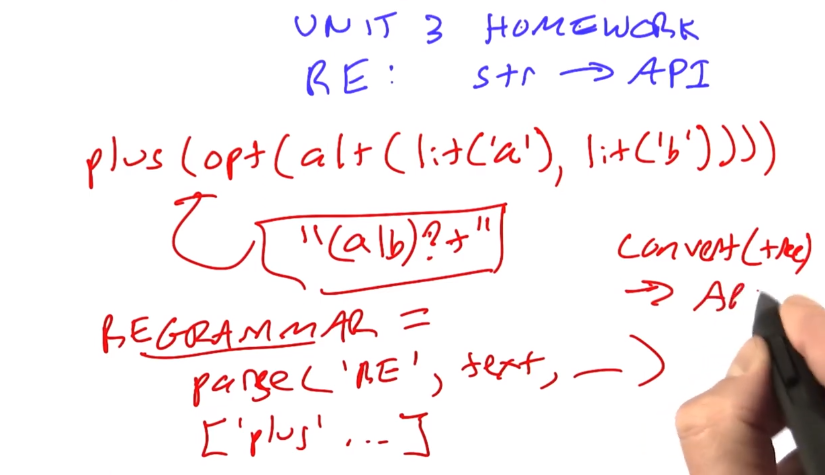

In [ ]:
# TODO
REGRAMMAR = grammar("""
""",whitespace='')

def parse_re(pattern):
    return convert(parse('RE',pattern,REGRAMMAR))

def convert(tree):
    # TODO